# Multimodal Emotion Recognition (MELD)

The goal of this project is the development of a reliable multimodal system for automatic emotion classification using state-of-the-art deep learning models for natural language and speech processing.

The proposed system employs a pre-trained **BERT** model for the representation and processing of textual data, as well as the **wav2vec 2.0 model** for acoustic feature extraction from speech signals. Information from different modalities is integrated through **multimodal fusion techniques** on the **MELD dataset**.

Two fusion strategies are investigated: early fusion and late fusion. **Early fusion** performs joint modeling of textual and acoustic features at an early stage, while **late fusion** combines independently learned modality-specific representations at a later decision level.

## 1. Setup and Configuration


### Environment Setup
Standard libraries for data processing, audio signal handling, and deep learning are loaded. In addition, the required packages for audio processing, working with pre-trained models, and PyTorch-based implementation are installed and configured.

In [ ]:
# System setup and dependencies

!sudo apt-get update
!sudo apt-get install ffmpeg
!pip install torch==2.9.0 torchvision==0.24.0 torchaudio==2.9.0 --index-url https://download.pytorch.org/whl/cu126

In [ ]:
# Additional Python packages for AI/Audio/NLP

!pip -q install transformers datasets accelerate sentencepiece

!pip install -q librosa soundfile

!pip install torchcodec==0.8.0

In [ ]:
import numpy as np
import pandas as pd
import time
import math
import random
import os
import shutil
import subprocess
import warnings
warnings.filterwarnings('ignore')
from pathlib import Path

# PyTorch ecosystem imports
import torch
import torchaudio
import torchcodec
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Hugging Face transformers - Multimodal Models
from transformers import (
    Wav2Vec2Processor,
    Wav2Vec2Model,

    BertConfig,
    BertModel,
    BertTokenizer
)

# Progress bar for iterations
from tqdm.auto import tqdm

# Evalution metrics
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# Google Drive is used to store the MELD dataset and to save the processed audio embeddings.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Configuration
All project parameters are defined in a centralized configuration dictionary to ensure clarity, consistency and reproducibility of experiments. The configuration includes dataset specifications, model architecture parameters, fusion settings, training hyperparameters, evaluation criteria, and hardware selection.

To ensure experimental reproducibility, all sources of randomness are controlled by explicitly setting a global random seed. By fixing the random seed and centralizing all parameters within the configuration dictionary, the experimental setup can be reliably reproduced across different runs and hardware environments.

In [ ]:
# Project configuration (DICTIONARY FORMAT)

CONFIG = {
    # Dataset parameters
    "dataset_name": "declare-lab/MELD",
    "emotion_labels": ["neutral", "joy", "surprise", "anger", "sadness", "fear", "disgust"],

    # Sample limits for faster testing
    "max_train_samples": None,   # Original: 9989
    "max_val_samples": None,     # Original: 1109
    "max_test_samples": None,    # Original: 2610

    # Models parameters
    "bert_model": "bert-base-uncased",
    "wav2vec_model": "facebook/wav2vec2-base",
    "bert_hidden_size": 768,
    "wav2vec_hidden_size": 768,
    "max_text_length": 128,
    "audio_sampling_rate": 16000,
    "text_embedding_dim": 768,
    "audio_embedding_dim": 768,

    # Early Fusion
    "fusion_input_dim": 1536,
    "fusion_hidden_dim":512,
    "fusion_dropout":0.3,
    "num_classes": 7,

    # Training hyperparameters
    "batch_size": 32,
    "num_epochs": 30,
    "learning_rate": 1e-4,
    "weight_decay": 1e-4,
    "early_stopping_patience": 5,

    # Evaluation
    "eval_metrics": ["accuracy", "weighted_f1", "confusion_matrix"],
    "random_seed": 42,

    # Hardware
    "device": "cuda" if torch.cuda.is_available() else "cpu",

     # Project info
    "project_name": "Multimodal Emotion Recognition in Conversations",
}

def print_config(config):
    """Display configuration in a readable format"""
    print("=" * 70)
    print(f"CONFIGURATION: {config['project_name']}")
    print("=" * 70)

    sections = {
        "Dataset": ["dataset_name", "emotion_labels", "max_train_samples"],
        "Models": ["bert_model", "wav2vec_model", "bert_hidden_size","wav2vec_hidden_size"],
        "Training": ["batch_size", "num_epochs", "learning_rate", "weight_decay"],
        "Hardware": ["device"],
        "Evaluation": ["eval_metrics", "random_seed"]
    }

    for section, keys in sections.items():
        print(f"\n[{section}]")
        for key in keys:
            if key in config:
                value = config[key]
                if isinstance(value, list) and len(value) > 3:
                    print(f"  {key}: [{value[0]}, {value[1]}, ..., {value[-1]}] (len={len(value)})")
                else:
                    print(f"  {key}: {value}")
        print("=" * 70)

# Display configuration
print_config(CONFIG)

CONFIGURATION: Multimodal Emotion Recognition in Conversations

[Dataset]
  dataset_name: declare-lab/MELD
  emotion_labels: [neutral, joy, ..., disgust] (len=7)
  max_train_samples: None

[Models]
  bert_model: bert-base-uncased
  wav2vec_model: facebook/wav2vec2-base
  bert_hidden_size: 768
  wav2vec_hidden_size: 768

[Training]
  batch_size: 32
  num_epochs: 30
  learning_rate: 0.0001
  weight_decay: 0.0001

[Hardware]
  device: cuda

[Evaluation]
  eval_metrics: ['accuracy', 'weighted_f1', 'confusion_matrix']
  random_seed: 42


In [ ]:
# Set seeds
def set_seed(seed=42):
    """Set all random seeds for reproducibility"""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

# Use seed from CONFIG
set_seed(CONFIG["random_seed"])


print(f"PyTorch: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

PyTorch: 2.9.0+cu126
CUDA available: True
GPU: Tesla T4
GPU Memory: 15.8 GB


### Paths and Directory Structure
This section defines the directory structure used in the project, separating
runtime data from persistent Google Drive storage.
Directories are organized for raw data, processed audio files, CSV metadata,
and extracted embeddings, and are created automatically to ensure reproducibility.


In [ ]:

# ROOT DIRECTORIES
RUNTIME_ROOT = Path("/content")
DRIVE_ROOT = Path("/content/drive/MyDrive/datasets/MELD")
MODEL_ROOT = Path("/content/drive/MyDrive/models")

# RAW MELD DATA
# Directory where the original MELD dataset will be extracted
MELD_RAW_ROOT = RUNTIME_ROOT / "meld_raw"

# Dataset splits after extraction
MELD_TRAIN_DIR = MELD_RAW_ROOT / "train"
MELD_DEV_DIR   = MELD_RAW_ROOT / "dev"
MELD_TEST_DIR  = MELD_RAW_ROOT / "test"


# FILTERED / PROCESSED DATA
MELD_FILTERED_ROOT = RUNTIME_ROOT / "meld_filtered"

# Local audio and CSV files
AUDIO_WAV_DIR = DRIVE_ROOT / "meld_filtered" / "audio_wav"
CSV_LOCAL_DIR = DRIVE_ROOT / "meld_filtered" / "csv"

# CSV Files (GOOGLE DRIVE)
CSV_DRIVE_DIR = DRIVE_ROOT / "meld_filtered" / "csv"

TRAIN_CSV_PATH = CSV_DRIVE_DIR / "train_sent_emo.csv"
VAL_CSV_PATH   = CSV_DRIVE_DIR / "dev_sent_emo.csv"
TEST_CSV_PATH  = CSV_DRIVE_DIR / "test_sent_emo.csv"

# EMBEDDINGS
AUDIO_EMBEDDINGS_DIR = DRIVE_ROOT / "embeddings"
TEXT_EMBEDDINGS_DIR  = DRIVE_ROOT / "embeddings_text"


# Create required directories
for p in [
    MELD_RAW_ROOT,
    MELD_TRAIN_DIR, MELD_DEV_DIR, MELD_TEST_DIR,
    MELD_FILTERED_ROOT,
    AUDIO_WAV_DIR, CSV_LOCAL_DIR,
    AUDIO_EMBEDDINGS_DIR, TEXT_EMBEDDINGS_DIR,
    MODEL_ROOT
]:
    p.mkdir(parents=True, exist_ok=True)

## 2. Dataset Preparation

### Dataset Download and Extraction
The MELD dataset is downloaded and extracted into separate directories for train, validation, and test splits. Audio files (originally MP4) are converted to mono WAV at 16 kHz to ensure compatibility with the wav2vec 2.0 model.



In [ ]:
!wget -O meld.zip https://huggingface.co/datasets/declare-lab/MELD/resolve/main/MELD.Raw.tar.gz

--2026-01-16 18:23:23--  https://huggingface.co/datasets/declare-lab/MELD/resolve/main/MELD.Raw.tar.gz
Resolving huggingface.co (huggingface.co)... 52.222.136.117, 52.222.136.38, 52.222.136.92, ...
Connecting to huggingface.co (huggingface.co)|52.222.136.117|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://us.gcp.cdn.hf.co/xet-bridge-us/6356101360c1b72f626ab49f/714191188117577a467426e969011bbee103072d7364b6b6737423128204e197?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27MELD.Raw.tar.gz%3B+filename%3D%22MELD.Raw.tar.gz%22%3B&response-content-type=application%2Fgzip&Expires=1768591403&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiRXBvY2hUaW1lIjoxNzY4NTkxNDAzfX0sIlJlc291cmNlIjoiaHR0cHM6Ly91cy5nY3AuY2RuLmhmLmNvL3hldC1icmlkZ2UtdXMvNjM1NjEwMTM2MGMxYjcyZjYyNmFiNDlmLzcxNDE5MTE4ODExNzU3N2E0Njc0MjZlOTY5MDExYmJlZTEwMzA3MmQ3MzY0YjZiNjczNzQyMzEyODIwNGUxOTdcXD9yZXNwb25zZS1jb250ZW50LWRpc3Bvc2l0aW9uPSomcmVzcG9uc2UtY29udGVudC10e

In [ ]:
# Unzip MELD dataset
!tar -xvzf meld.zip -C {MELD_RAW_ROOT}

# Unzip splits
!tar -xvzf {MELD_RAW_ROOT}/MELD.Raw/train.tar.gz -C {MELD_TRAIN_DIR}
!tar -xvzf {MELD_RAW_ROOT}/MELD.Raw/dev.tar.gz   -C {MELD_DEV_DIR}
!tar -xvzf {MELD_RAW_ROOT}/MELD.Raw/test.tar.gz  -C {MELD_TEST_DIR}

In [ ]:
# Find all MP4 files recursive
mp4_files = list(MELD_RAW_ROOT.rglob("*.mp4"))
print("Found MP4 files:", len(mp4_files))

for mp4 in tqdm(mp4_files):
    wav_path = AUDIO_WAV_DIR / f"{mp4.stem}.wav"

    if wav_path.exists():
        continue

    subprocess.run(
        [
            "ffmpeg",
            "-y",
            "-i", str(mp4),
            "-ac", "1",
            "-ar", "16000",
            str(wav_path)
        ],
        stdout=subprocess.DEVNULL,
        stderr=subprocess.DEVNULL
    )

print("MP4 → WAV conversion finished.")

Found MP4 files: 15908


  0%|          | 0/15908 [00:00<?, ?it/s]

MP4 → WAV conversion finished.


In [ ]:
from pathlib import Path

print("MELD_RAW_ROOT exists?", MELD_RAW_ROOT.exists())
print("Contents:", list(MELD_RAW_ROOT.glob("*")))


MELD_RAW_ROOT exists? True
Contents: [PosixPath('/content/meld_raw/train'), PosixPath('/content/meld_raw/test'), PosixPath('/content/meld_raw/dev'), PosixPath('/content/meld_raw/MELD.Raw')]


In [ ]:
# Copy WAV files
!find "{str(MELD_RAW_ROOT)}" -type f -name "*.wav" -exec cp {{}} "{str(AUDIO_WAV_DIR)}" \;

# Copy CSV files
!find "{str(MELD_RAW_ROOT)}" -type f -name "*.csv" -exec cp {{}} "{str(CSV_LOCAL_DIR)}" \;

# Copy on Google Drive
!cp -r {MELD_FILTERED_ROOT} {DRIVE_ROOT}

### Loading CSV Metadata
This section loads the CSV metadata files for the training, validation, and test splits
and prints their dimensions to verify successful loading.




In [ ]:
train_df = pd.read_csv(TRAIN_CSV_PATH)
val_df   = pd.read_csv(VAL_CSV_PATH)
test_df  = pd.read_csv(TEST_CSV_PATH)

print(train_df.shape, val_df.shape, test_df.shape)

(9989, 11) (1109, 11) (2610, 11)


### Data Preprocessing
Emotion labels are mapped from textual categories to numerical class indices to enable
model training.
For each utterance, the absolute path to the corresponding WAV audio file is constructed
based on its dialogue and utterance identifiers.
Column names are standardized to ensure consistency across dataset splits.

In [ ]:
# Map emotion labels to numeric classes
EMOTION_MAP = {
    "neutral": 0,
    "joy": 1,
    "surprise": 2,
    "anger": 3,
    "sadness": 4,
    "fear": 5,
    "disgust": 6
}

# Build absolute path to WAV audio file
def build_audio_path(dialogue_id, utterance_id):
    return AUDIO_WAV_DIR / f"dia{dialogue_id}_utt{utterance_id}.wav"

# Prepare DataFrame for audio-based emotion classification
def prepare_df(df):
    # Create a copy of the dataframe to avoid in-place modifications
    df = df.copy()

    # Map emotion labels to numeric classes
    df["label"] = df["Emotion"].map(EMOTION_MAP)

    # Build the path to the corresponding audio file for each utterance
    df["audio_path"] = df.apply(
    lambda x: build_audio_path(x.Dialogue_ID, x.Utterance_ID),
    axis=1
)
    # Standardize column names
    df.rename(columns={"Utterance": "utterance"}, inplace=True)
    return df

# Apply preprocessing to train, val and test splits
train_df = prepare_df(train_df)
val_df   = prepare_df(val_df)
test_df  = prepare_df(test_df)

In [ ]:
print(train_df.iloc[0]["audio_path"])
print(os.path.exists(train_df.iloc[0]["audio_path"]))

/content/meld_filtered/audio_wav/dia0_utt0.wav
True


### Audio Data Verification
A sample audio file is loaded and played to verify that the audio preprocessing was performed correctly.



In [ ]:
from IPython.display import Audio

sample_path = train_df.iloc[0]["audio_path"]
Audio(sample_path)

## 6. Audio Embeddings (Wav2Vec 2.0)

A custom PyTorch Dataset class loads waveform–label pairs, converting audio to mono and truncating signals to 6 seconds for consistent input length.

Audio features are extracted using the pre-trained Wav2Vec 2.0 model. Each waveform is processed with the corresponding processor and passed through the model to obtain hidden representations. The mean over the time dimension is used to produce a fixed-size embedding for every utterance.

Embeddings and their associated labels are saved in .pt files for the train, validation, and test splits and are later used as inputs for the multimodal classification pipeline

In [ ]:
wav2vec_processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base")

wav2vec_model = Wav2Vec2Model.from_pretrained(
    "facebook/wav2vec2-base"
).to(CONFIG["device"])

wav2vec_model.eval()

preprocessor_config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/163 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/380M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/380M [00:00<?, ?B/s]

Wav2Vec2Model(
  (feature_extractor): Wav2Vec2FeatureEncoder(
    (conv_layers): ModuleList(
      (0): Wav2Vec2GroupNormConvLayer(
        (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
        (activation): GELUActivation()
        (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
      )
      (1-4): 4 x Wav2Vec2NoLayerNormConvLayer(
        (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
        (activation): GELUActivation()
      )
      (5-6): 2 x Wav2Vec2NoLayerNormConvLayer(
        (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
        (activation): GELUActivation()
      )
    )
  )
  (feature_projection): Wav2Vec2FeatureProjection(
    (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (projection): Linear(in_features=512, out_features=768, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): Wav2Vec2Encoder(
    (pos_conv_embed): Wav2Vec2PositionalConvEmbedding(
  

In [ ]:
class MELDAudioDataset(Dataset):
    def __init__(self, df):
        self.df = df.reset_index(drop=True)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        path = self.df.loc[idx, "audio_path"]
        label = self.df.loc[idx, "label"]

        waveform, sr = torchaudio.load(path)
        waveform = waveform.mean(dim=0)       # mono
        waveform = waveform[: sr * 6]          # max 6 seconds

        return waveform, label

In [ ]:
def extract_audio_embeddings(df, save_path):
    dataset = MELDAudioDataset(df)
    loader = DataLoader(dataset, batch_size=1, shuffle=False)

    embeddings, labels = [], []

    with torch.no_grad():
        for waveform, label in tqdm(loader):
            waveform = waveform.squeeze().numpy()

            inputs = wav2vec_processor(
                waveform,
                sampling_rate=16000,
                return_tensors="pt"
            ).input_values.to(CONFIG["device"])

            outputs = wav2vec_model(inputs)
            emb = outputs.last_hidden_state.mean(dim=1)

            embeddings.append(emb.cpu())
            labels.append(label)

            del emb, inputs, outputs
            torch.cuda.empty_cache()

    torch.save(
        {
            "embeddings": torch.cat(embeddings),
            "labels": torch.tensor(labels)
        },
        save_path
    )

In [ ]:
extract_audio_embeddings(
    train_df,
    AUDIO_EMBEDDINGS_DIR / "audio_train.pt"
)
extract_audio_embeddings(
    val_df,
    AUDIO_EMBEDDINGS_DIR / "audio_val.pt"
)
extract_audio_embeddings(
    test_df,
    AUDIO_EMBEDDINGS_DIR / "audio_test.pt"
)


  0%|          | 0/9989 [00:00<?, ?it/s]

  0%|          | 0/1109 [00:00<?, ?it/s]

  0%|          | 0/2610 [00:00<?, ?it/s]

In [ ]:
train_data = torch.load(AUDIO_EMBEDDINGS_DIR / "audio_train.pt")
val_data   = torch.load(AUDIO_EMBEDDINGS_DIR / "audio_val.pt")
test_data  = torch.load(AUDIO_EMBEDDINGS_DIR / "audio_test.pt")

train_audio_embeddings = train_data["embeddings"]
val_audio_embeddings = val_data["embeddings"]
test_audio_embeddings = test_data["embeddings"]

train_labels = train_data["labels"]
val_labels = val_data["labels"]
test_labels = test_data["labels"]

print(train_audio_embeddings.shape, train_labels.shape)

torch.Size([9989, 768]) torch.Size([9989])


## 7. Text Embeddings (BERT)

Textual features are extracted using a pre-trained BERT model. Each utterance is tokenized and encoded, then passed through the model to obtain contextualized representations. A fixed-size sentence embedding is derived from the output and used as the text modality input for the multimodal system.

The resulting embeddings and corresponding labels are stored for the train, validation, and test splits and later combined with audio features in the fusion stage.

In [ ]:
# Load tokenizer and model
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = BertModel.from_pretrained("bert-base-uncased").to(CONFIG["device"])
bert_model.eval()

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [ ]:
class MELDTextDataset(Dataset):
    def __init__(self, df):
        self.df = df.reset_index(drop=True)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        text = self.df.loc[idx, "utterance"]
        label = self.df.loc[idx, "label"]
        return text, label


In [ ]:
def extract_text_embeddings(df, save_path, max_length=128):
    dataset = MELDTextDataset(df)
    loader = DataLoader(dataset, batch_size=8, shuffle=False)

    embeddings, labels = [], []

    with torch.no_grad():
        for texts, batch_labels in tqdm(loader):
            inputs = bert_tokenizer(
                list(texts),
                padding=True,
                truncation=True,
                max_length=max_length,
                return_tensors="pt"
            )

            input_ids = inputs["input_ids"].to(CONFIG["device"])
            attention_mask = inputs["attention_mask"].to(CONFIG["device"])

            outputs = bert_model(input_ids=input_ids, attention_mask=attention_mask)
            last_hidden = outputs.last_hidden_state  # (batch_size, seq_len, hidden_dim)

            # Mean pooling over valid tokens
            mask = attention_mask.unsqueeze(-1).expand(last_hidden.size()).float()
            summed = torch.sum(last_hidden * mask, dim=1)
            counts = torch.clamp(mask.sum(dim=1), min=1e-9)
            mean_pooled = summed / counts  # (batch_size, hidden_dim)

            embeddings.append(mean_pooled.cpu())
            labels.append(batch_labels)

            del inputs, outputs, mean_pooled
            torch.cuda.empty_cache()

    torch.save(
        {
            "embeddings": torch.cat(embeddings),
            "labels": torch.cat(labels)
        },
        save_path
    )


In [ ]:
extract_text_embeddings(
    train_df,
    TEXT_EMBEDDINGS_DIR / "text_train.pt",
    max_length=CONFIG["max_text_length"]
)

extract_text_embeddings(
    val_df,
    TEXT_EMBEDDINGS_DIR / "text_val.pt",
    max_length=CONFIG["max_text_length"]
)

extract_text_embeddings(
    test_df,
    TEXT_EMBEDDINGS_DIR / "text_test.pt",
    max_length=CONFIG["max_text_length"]
)


  0%|          | 0/1249 [00:00<?, ?it/s]

  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/327 [00:00<?, ?it/s]

In [ ]:
train_data = torch.load(TEXT_EMBEDDINGS_DIR / "text_train.pt")
val_data   = torch.load(TEXT_EMBEDDINGS_DIR / "text_val.pt")
test_data  = torch.load(TEXT_EMBEDDINGS_DIR / "text_test.pt")

train_text_embeddings = train_data["embeddings"]
val_text_embeddings = val_data["embeddings"]
test_text_embeddings = test_data["embeddings"]

#train_labels     = train_data["labels"]

print(train_text_embeddings.shape, train_labels.shape)


torch.Size([9989, 768]) torch.Size([9989])


## Dataset Definition

In [ ]:
class MultimodalDataset(Dataset):
    def __init__(self, text_embeddings, audio_embeddings, labels):
        self.text_embeddings = text_embeddings
        self.audio_embeddings = audio_embeddings
        self.labels = labels

    # Return the total number of samples
    def __len__(self):
        return len(self.labels)

    # Return one multimodal sample
    def __getitem__(self, idx):
        return (
            self.text_embeddings[idx],
            self.audio_embeddings[idx],
            self.labels[idx]
        )

## Model Definitions

### Early Fusion Model  (Concatenation + MLP)

The early fusion approach is implemented by concatenating textual and audio embeddings of dimension 768, extracted using the BERT and wav2vec 2.0 models. In this way, a joint multimodal representation of dimension 1536 is formed, combining information from both modalities.

The resulting fused vector is passed to a multilayer perceptron (MLP) consisting of linear layers with ReLU activation functions and dropout regularization, which helps reduce the risk of overfitting. The final layer performs emotion classification, while the softmax function is implicitly applied through the cross-entropy loss function.

In [ ]:
# Early Fusion model for multimodal emotion recognition.
class EarlyFusionMLP(nn.Module):
  def __init__(self, config):
    super(EarlyFusionMLP, self).__init__()

    # Dimension of the fused multimodal representation
    fusion_dim = config["text_embedding_dim"] + config["audio_embedding_dim"]

    # Multilayer perceptron used for classification
    self.classifier = nn.Sequential(
        nn.Linear(fusion_dim, config["fusion_hidden_dim"]),
        nn.ReLU(),
        nn.Dropout(p=config["fusion_dropout"]),

        nn.Linear(config["fusion_hidden_dim"], 256),
        nn.ReLU(),
        nn.Dropout(p=config["fusion_dropout"]),

        nn.Linear(256, config["num_classes"])
      )

  # Forward pass of the model.
  def forward(self, text_emb, audio_emb):
    # Concatenate text and audio embeddings along the feature dimension
    fused = torch.cat((text_emb, audio_emb),dim = 1)
    # Pass the fused representation through the classifier
    logits = self.classifier(fused)
    return logits

### Unimodal Baseline Models
Separate classifiers are defined for text-only and audio-only emotion recognition.


In [ ]:
# Text-only classifier based on BERT embeddings
class TextClassifier(nn.Module):

    def __init__(self, config):
        super(TextClassifier, self).__init__()

        self.classifier = nn.Sequential(
            nn.Linear(config["text_embedding_dim"], 256),
            nn.ReLU(),
            nn.Dropout(config["fusion_dropout"]),
            nn.Linear(256, config["num_classes"])
        )

    def forward(self, text_emb):
        return self.classifier(text_emb)


In [ ]:
# Audio-only classifier based on wav2vec 2.0 embeddings
class AudioClassifier(nn.Module):
    def __init__(self, config):
        super(AudioClassifier, self).__init__()

        self.classifier = nn.Sequential(
            nn.Linear(config["audio_embedding_dim"], 256),
            nn.ReLU(),
            nn.Dropout(config["fusion_dropout"]),
            nn.Linear(256, config["num_classes"])
        )

    def forward(self, audio_emb):
        return self.classifier(audio_emb)


## Training and Evaluation Utilities

This section defines shared training, evaluation, and visualization utilities used across all models and fusion strategies. The `Trainer` class provides a unified training pipeline supporting text-only, audio-only, and early fusion modes, including loss computation, optimization, learning rate scheduling, checkpointing, and early stopping based on validation F1-score.

Late fusion is evaluated separately by combining independently trained text and audio model logits via a weighted average at inference time. Model performance is assessed using accuracy, weighted F1-score, and confusion matrices, while additional visualization utilities enable per-class and fusion-level performance analysis.



In [ ]:
class Trainer:
  def __init__(self, model, train_loader, val_loader, config, mode="early_fusion"):
    self.model = model
    self.train_loader = train_loader
    self.val_loader = val_loader
    self.config = config
    self.mode =mode

    self.device = torch.device(config["device"])
    self.model.to(self.device)

    self.criterion = nn.CrossEntropyLoss()
    self.optimizer = Adam(self.model.parameters(), lr=config["learning_rate"])
    self.scheduler = ReduceLROnPlateau(self.optimizer, mode='max', patience=2)

    self.best_f1 = 0.0
    self.epochs_no_improve = 0

    self.ckpt_dir = MODEL_ROOT / "checkpoints"
    self.ckpt_dir.mkdir(parents=True, exist_ok=True)
    self.ckpt_path = self.ckpt_dir / f"{mode}_best.pt"

  def _forward(self, batch):
    text, audio, labels = batch
    if self.mode == "early_fusion":
      logits = self.model(text, audio)
    elif self.mode == "text":
      logits = self.model(text)
    elif self.mode == "audio":
      logits = self.model(audio)
    else:
      raise ValueError("Unknown mode")
    return logits, labels

  def train_epoch(self):
    self.model.train()
    total_loss = 0
    for batch in self.train_loader:
      batch = [b.to(self.device) for b in batch]
      self.optimizer.zero_grad()
      logits, labels = self._forward(batch)
      loss = self.criterion(logits, labels)
      loss.backward()
      self.optimizer.step()
      total_loss += loss.item()
    return total_loss / len(self.train_loader)

  def evaluate(self, return_cm=False):
      self.model.eval()
      preds, targets = [], []

      with torch.no_grad():
          for batch in self.val_loader:
              batch = [b.to(self.device) for b in batch]
              logits, labels = self._forward(batch)

              preds.extend(torch.argmax(logits, dim=1).cpu().numpy())
              targets.extend(labels.cpu().numpy())

      acc = accuracy_score(targets, preds)
      f1 = f1_score(targets, preds, average="weighted")

      if return_cm:
          cm = confusion_matrix(targets, preds)
          return{
            "accuracy": acc,
            "f1": f1,
            "y_true": targets,
            "y_pred": preds,
            "confusion_matrix": cm
          }

      return acc, f1

  def save_checkpoint(self, epoch, f1):
    torch.save({
      'epoch': epoch,
      'model_state': self.model.state_dict(),
      'optimizer_state': self.optimizer.state_dict(),
      'f1': f1,
      'mode': self.mode,
      'config': self.config
    }, self.ckpt_path)

  def fit(self):
    for epoch in range(self.config["num_epochs"]):
      train_loss = self.train_epoch()
      val_acc, val_f1 = self.evaluate()
      self.scheduler.step(val_f1)

      print(f"[{self.mode}] Epoch {epoch+1}: loss={train_loss:.4f}, val_f1={val_f1:.4f}")

      if val_f1 > self.best_f1:
        self.best_f1 = val_f1
        self.epochs_no_improve = 0
        self.save_checkpoint(epoch, val_f1)
      else:
        self.epochs_no_improve += 1

      if self.epochs_no_improve >= self.config["early_stopping_patience"]:
        print("Early stopping triggered")
        break

In [ ]:
def load_model(path, device='cpu'):
    ckpt = torch.load(path, map_location=device)
    config = ckpt['config']
    mode = ckpt.get('mode', 'early_fusion')

    if mode == "early_fusion":
        model = EarlyFusionMLP(config)
    elif mode == "text":
        model = TextClassifier(config)
    elif mode == "audio":
        model = AudioClassifier(config)
    else:
        raise ValueError(f"Unknown model mode: {mode}")

    model.load_state_dict(ckpt['model_state'])
    model.to(device)
    model.eval()
    return model


In [ ]:
# Evaluates late fusion model (average or weighted).
def evaluate_late_fusion(text_model, audio_model, dataloader, device, alpha=0.5):
    text_model.eval()
    audio_model.eval()

    all_preds, all_labels = [], []

    with torch.no_grad():
        for text_emb, audio_emb, labels in dataloader:
            text_logits = text_model(text_emb.to(device))
            audio_logits = audio_model(audio_emb.to(device))

            fused_logits = alpha * text_logits + (1 - alpha) * audio_logits
            all_preds.extend(torch.argmax(fused_logits, dim=1).cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average="weighted")
    cm = confusion_matrix(all_labels, all_preds)

    return{
            "accuracy": acc,
            "f1": f1,
            "y_true": all_labels,
            "y_pred": all_preds,
            "confusion_matrix": cm
    }

In [ ]:
# Plots a confusion matrix for classification results.
def plot_confusion_matrix(
    y_true,
    y_pred,
    class_names,
    title="Confusion Matrix",
    normalize=False,
    figsize=(8, 6),
    cmap="Blues"
):

    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype(np.float32) / cm.sum(axis=1, keepdims=True)
        fmt = ".2f"
    else:
        fmt = "d"

    plt.figure(figsize=figsize)
    sns.heatmap(
        cm,
        annot=True,
        fmt=fmt,
        cmap=cmap,
        xticklabels=class_names,
        yticklabels=class_names
    )
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(title)
    plt.tight_layout()
    plt.show()

In [ ]:
# Plots per-class F1-scores as a bar chart.
def plot_per_class_f1(
    y_true,
    y_pred,
    class_names,
    title="Per-class F1-score",
    figsize=(8, 5),
    ylim=(0.0, 1.0)
):

    precision, recall, f1, support = precision_recall_fscore_support(
        y_true,
        y_pred,
        labels=range(len(class_names)),
        average=None
    )

    x = np.arange(len(class_names))

    plt.figure(figsize=figsize)
    bars = plt.bar(x, f1)

    plt.xticks(x, class_names, rotation=45, ha="right")
    plt.ylabel("F1-score")
    plt.ylim(ylim)
    plt.title(title)

    # Annotate bars with values
    for bar, score in zip(bars, f1):
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height() + 0.01,
            f"{score:.2f}",
            ha="center",
            va="bottom",
            fontsize=9
        )

    plt.tight_layout()
    plt.show()


In [ ]:
def plot_per_class_f1_comparison(
    y_true_early,
    y_pred_early,
    y_true_late,
    y_pred_late,
    class_names,
    figsize=(9, 5)
):
    _, _, f1_early, _ = precision_recall_fscore_support(
        y_true_early, y_pred_early,
        labels=range(len(class_names)),
        average=None
    )

    _, _, f1_late, _ = precision_recall_fscore_support(
        y_true_late, y_pred_late,
        labels=range(len(class_names)),
        average=None
    )

    x = np.arange(len(class_names))
    width = 0.35

    plt.figure(figsize=figsize)
    plt.bar(x - width/2, f1_early, width, label="Early Fusion")
    plt.bar(x + width/2, f1_late, width, label="Late Fusion")

    plt.xticks(x, class_names, rotation=45, ha="right")
    plt.ylabel("F1-score")
    plt.ylim(0.0, 1.0)
    plt.title("Per-class F1-score Comparison")
    plt.legend()
    plt.tight_layout()
    plt.show()


### Multimodal Dataset Construction
Text and audio embeddings are grouped into a `MultimodalDataset` for train, validation, and test splits. DataLoaders are used to load data in batches, with shuffling applied only during training.




In [ ]:
# Create datasets
train_dataset = MultimodalDataset(
    train_text_embeddings,
    train_audio_embeddings,
    train_labels
)

val_dataset = MultimodalDataset(
    val_text_embeddings,
    val_audio_embeddings,
    val_labels
)
test_dataset = MultimodalDataset(
    test_text_embeddings,
    test_audio_embeddings,
    test_labels
)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset,batch_size=32,shuffle=False)

## Model Training




### Early Fusion Training

In [ ]:
# Early fusion model
early_fusion_model  = EarlyFusionMLP(CONFIG).to(CONFIG["device"])

# Training
trainer_early_fusion = Trainer(
    early_fusion_model,
    train_loader,
    val_loader,
    CONFIG,
    mode = "early_fusion")
trainer_early_fusion.fit()

[early_fusion] Epoch 1: loss=1.3810, val_f1=0.4769
[early_fusion] Epoch 2: loss=1.1866, val_f1=0.5094
[early_fusion] Epoch 3: loss=1.1314, val_f1=0.5311
[early_fusion] Epoch 4: loss=1.1013, val_f1=0.5479
[early_fusion] Epoch 5: loss=1.0793, val_f1=0.5480
[early_fusion] Epoch 6: loss=1.0636, val_f1=0.5472
[early_fusion] Epoch 7: loss=1.0525, val_f1=0.5480
[early_fusion] Epoch 8: loss=1.0354, val_f1=0.5672
[early_fusion] Epoch 9: loss=1.0222, val_f1=0.5605
[early_fusion] Epoch 10: loss=1.0068, val_f1=0.5635
[early_fusion] Epoch 11: loss=0.9929, val_f1=0.5668
[early_fusion] Epoch 12: loss=0.9664, val_f1=0.5761
[early_fusion] Epoch 13: loss=0.9548, val_f1=0.5740
[early_fusion] Epoch 14: loss=0.9523, val_f1=0.5739
[early_fusion] Epoch 15: loss=0.9500, val_f1=0.5728
[early_fusion] Epoch 16: loss=0.9453, val_f1=0.5728
[early_fusion] Epoch 17: loss=0.9424, val_f1=0.5744
Early stopping triggered


### Training Unimodal Baseline Models


In [ ]:
text_model = TextClassifier(CONFIG).to(CONFIG["device"])
trainer_text_baseline = Trainer(
    text_model,
    train_loader,
    val_loader,
    CONFIG,
    mode="text"
)
trainer_text_baseline.fit()


[text] Epoch 1: loss=1.3929, val_f1=0.4724
[text] Epoch 2: loss=1.1947, val_f1=0.5159
[text] Epoch 3: loss=1.1407, val_f1=0.5330
[text] Epoch 4: loss=1.1169, val_f1=0.5396
[text] Epoch 5: loss=1.0957, val_f1=0.5425
[text] Epoch 6: loss=1.0785, val_f1=0.5461
[text] Epoch 7: loss=1.0727, val_f1=0.5545
[text] Epoch 8: loss=1.0643, val_f1=0.5474
[text] Epoch 9: loss=1.0537, val_f1=0.5578
[text] Epoch 10: loss=1.0454, val_f1=0.5595
[text] Epoch 11: loss=1.0381, val_f1=0.5610
[text] Epoch 12: loss=1.0285, val_f1=0.5490
[text] Epoch 13: loss=1.0227, val_f1=0.5617
[text] Epoch 14: loss=1.0188, val_f1=0.5569
[text] Epoch 15: loss=1.0078, val_f1=0.5621
[text] Epoch 16: loss=1.0042, val_f1=0.5564
[text] Epoch 17: loss=0.9977, val_f1=0.5682
[text] Epoch 18: loss=0.9898, val_f1=0.5724
[text] Epoch 19: loss=0.9875, val_f1=0.5696
[text] Epoch 20: loss=0.9773, val_f1=0.5709
[text] Epoch 21: loss=0.9780, val_f1=0.5598
[text] Epoch 22: loss=0.9599, val_f1=0.5657
[text] Epoch 23: loss=0.9605, val_f1=0.56

In [ ]:
audio_model = AudioClassifier(CONFIG).to(CONFIG["device"])
trainer_audio_baseline = Trainer(
    audio_model,
    train_loader,
    val_loader,
    CONFIG,
    mode="audio"
)
trainer_audio_baseline.fit()

[audio] Epoch 1: loss=1.5595, val_f1=0.2526
[audio] Epoch 2: loss=1.5085, val_f1=0.2587
[audio] Epoch 3: loss=1.4973, val_f1=0.2587
[audio] Epoch 4: loss=1.4887, val_f1=0.2769
[audio] Epoch 5: loss=1.4819, val_f1=0.2589
[audio] Epoch 6: loss=1.4814, val_f1=0.2731
[audio] Epoch 7: loss=1.4743, val_f1=0.2745
[audio] Epoch 8: loss=1.4671, val_f1=0.2673
[audio] Epoch 9: loss=1.4670, val_f1=0.2657
Early stopping triggered


## Model Evaluation


### Load best Models
The best-performing models (based on validation performance) are loaded for final evaluation.


In [ ]:
early_fusion_model = load_model(
    MODEL_ROOT / "checkpoints" / "early_fusion_best.pt",
    CONFIG["device"]
)
trainer_early = Trainer(
    model=early_fusion_model,
    train_loader=None,
    val_loader=test_loader,
    config=CONFIG,
    mode="early_fusion"
)

In [ ]:
text_model = load_model(MODEL_ROOT / "checkpoints" / "text_best.pt", CONFIG["device"])
audio_model = load_model(MODEL_ROOT / "checkpoints" / "audio_best.pt", CONFIG["device"])

In [ ]:
trainer_text = Trainer(
    text_model,
    None,
    test_loader,
    CONFIG,
    mode="text"
)

trainer_audio = Trainer(
    audio_model,
    None,
    test_loader,
    CONFIG,
    mode="audio"
)

### Quantitative Evaluation Metrics

Models are evaluated using accuracy and weighted F1-score.

In [ ]:
early_fusion_results  = trainer_early.evaluate(return_cm=True)


In [ ]:
text_results = trainer_text.evaluate(return_cm=True)

text_acc = text_results["accuracy"]
text_f1  = text_results["f1"]

In [ ]:
audio_results = trainer_audio.evaluate(return_cm=True)

audio_acc = audio_results["accuracy"]
audio_f1  = audio_results["f1"]

In [ ]:
late_fusion_results = evaluate_late_fusion(
    text_model=text_model,
    audio_model=audio_model,
    dataloader=test_loader,
    device=CONFIG["device"],
    alpha=0.5
)

### Confusion Matrix Analysis

Confusion matrices provide insight into class-wise prediction behavior.

The early fusion confusion matrix shows strong performance on the neutral class, while other emotions are often misclassified as neutral. Rare classes such as fear and disgust remain the most challenging.


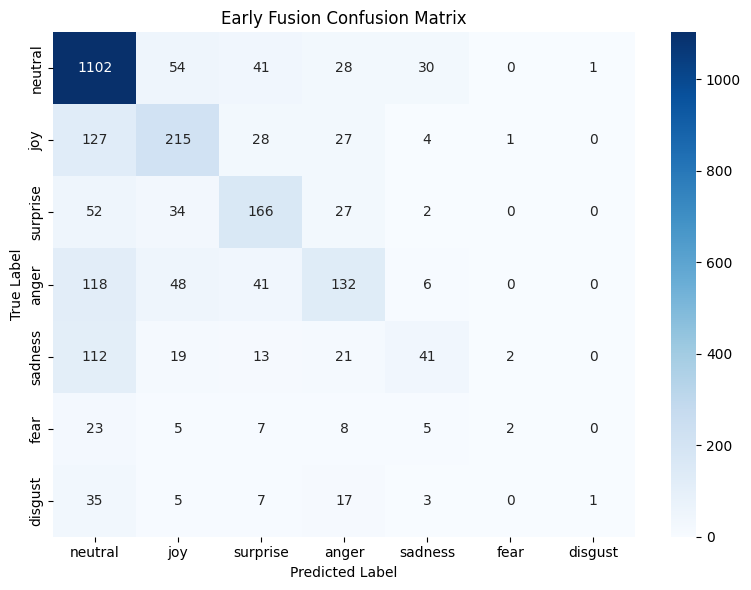

In [ ]:
plot_confusion_matrix(
    y_true=early_fusion_results["y_true"],
    y_pred=early_fusion_results["y_pred"],
    class_names=CONFIG["emotion_labels"],
    title="Early Fusion Confusion Matrix",
    normalize=False
)

The confusion matrix for the Early Fusion model is presented in a normalized form, where the values represent the proportion of correctly and incorrectly classified samples for each emotion class.The model exhibits a strong bias toward the neutral class, indicating limited discriminative power for minority emotion classes.

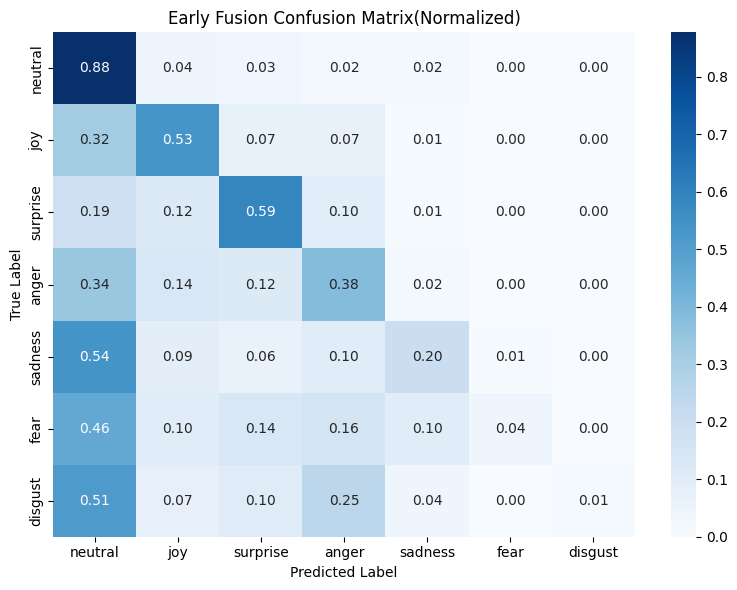

In [ ]:
plot_confusion_matrix(
    y_true=early_fusion_results["y_true"],
    y_pred=early_fusion_results["y_pred"],
    class_names=CONFIG["emotion_labels"],
    title="Early Fusion Confusion Matrix(Normalized)",
    normalize=True
)

The non-normalized confusion matrix shows the absolute number of predictions for the Late Fusion model.The largest number of correct predictions is obtained for the neutral class (1192 correctly classified samples). Most classification errors are caused by predicting emotional states as neutral, indicating the dominance of this class in the model output.

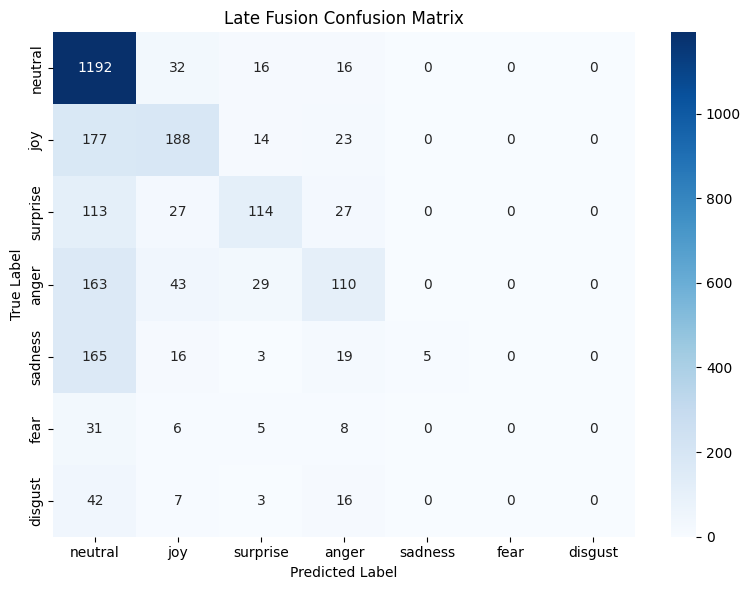

In [ ]:
plot_confusion_matrix(
    y_true=late_fusion_results["y_true"],
    y_pred=late_fusion_results["y_pred"],
    class_names=CONFIG["emotion_labels"],
    title="Late Fusion Confusion Matrix",
    normalize=False
)

The normalized confusion matrix for the Late Fusion model provides insight into the relative performance of each class. The sadness, fear, and disgust classes exhibit extremely low accuracies (0.02, 0.00, and 0.00), with the majority of samples being predicted as neutral.

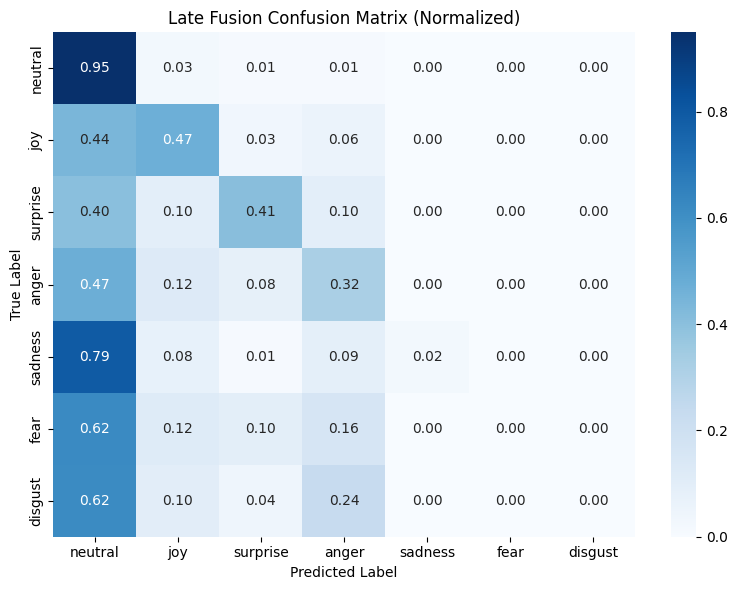

In [ ]:
plot_confusion_matrix(
    y_true=late_fusion_results["y_true"],
    y_pred=late_fusion_results["y_pred"],
    class_names=CONFIG["emotion_labels"],
    title="Late Fusion Confusion Matrix (Normalized)",
    normalize=True
)

### Per-class F1-score Analysis

Per-class F1-scores are visualized to analyze performance differences across emotion categories.


The Early Fusion model performs best on **Neutral** (0.78), with moderate results for **Surprise** (0.57) and **Joy** (0.55). Performance decreases for **Anger** (0.44) and **Sadness** (0.27), while **Fear** (0.07) and **Disgust** (0.03) are poorly recognized. Overall, the model favors dominant emotion classes and struggles with underrepresented ones.








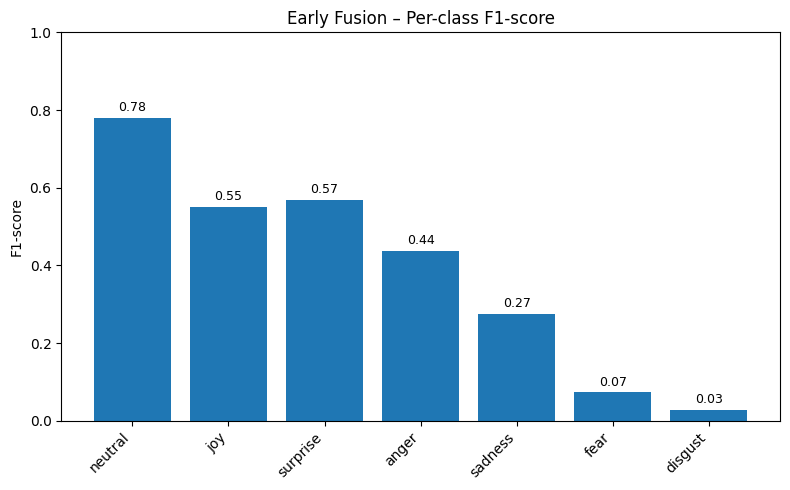

In [ ]:
plot_per_class_f1(
    y_true=early_fusion_results["y_true"],
    y_pred=early_fusion_results["y_pred"],
    class_names=CONFIG["emotion_labels"],
    title="Early Fusion – Per-class F1-score"
)

The model performs best on **neutral (0.76)**, followed by **joy (0.52)** and **surprise (0.49)**.  
Performance is lower for **anger (0.39)** and very poor for **sadness (0.05)**, while **fear** and **disgust** are not detected (**0.00**).


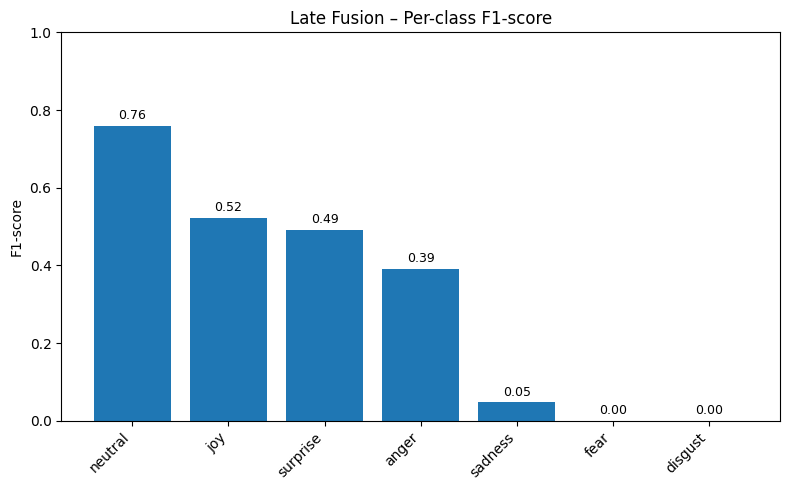

In [ ]:
plot_per_class_f1(
    y_true=late_fusion_results["y_true"],
    y_pred=late_fusion_results["y_pred"],
    class_names=CONFIG["emotion_labels"],
    title="Late Fusion – Per-class F1-score"
)

## Results

Table summarizes the performance of all models. The text baseline achieves good results, while the audio-only model performs notably worse. Early fusion slightly improves accuracy over the text baseline, whereas late fusion achieves lower overall performance but still outperforms the audio baseline.




In [ ]:
results_df = pd.DataFrame({
    "Model": [
        "Text baseline",
        "Audio baseline",
        "Early fusion",
        "Late fusion"
    ],
    "Accuracy": [
        text_results["accuracy"],
        audio_results["accuracy"],
        early_fusion_results["accuracy"],
        late_fusion_results["accuracy"]
    ],
    "Weighted F1": [
        text_results["f1"],
        audio_results["f1"],
        early_fusion_results["f1"],
        late_fusion_results["f1"]
    ]
})

results_df


,Model,Accuracy,Weighted F1
0,Text baseline,0.635249,0.607597
1,Audio baseline,0.470498,0.335281
2,Early fusion,0.635632,0.603014
3,Late fusion,0.616475,0.553895


Figure shows per-class F1-scores for early and late fusion. Early fusion performs better across most emotion classes, especially for less frequent emotions, while both methods perform best on neutral and joy.

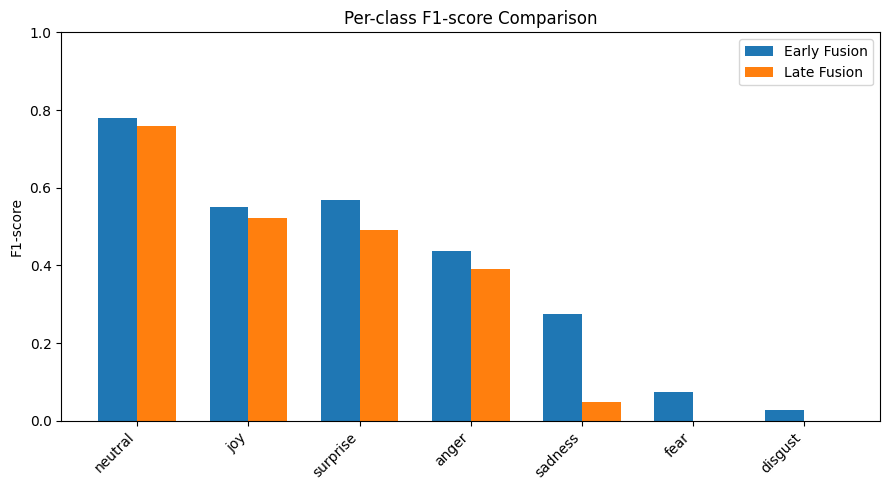

In [ ]:
plot_per_class_f1_comparison(
    early_fusion_results["y_true"],
    early_fusion_results["y_pred"],
    late_fusion_results["y_true"],
    late_fusion_results["y_pred"],
    class_names=CONFIG["emotion_labels"],
)